In [63]:
%matplotlib inline
import matplotlib.pyplot as plt

from math import sqrt
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torch.nn.functional as F

eps = np.random.normal(0, 3, 21)

x = np.asarray(list(range(-10, 11)))
y = x ** 2 + eps

print('x:', x[:5])
print('y:', y[:5])

def train_step(model, x, y, optimizer):
    optimizer.zero_grad()                  # Clear derivative
    
    # out = model(input)
    pred = model(to_tensor(x))             # Make Prediction
    
    
    # (out - y) ^ 2
    loss = F.mse_loss(pred, to_tensor(y))  # Grade prediction
    
    loss.backward()                        # Compute derivative
    
    optimizer.step()                       # Update weights
    return loss.item()

    
def train_reg(model, x, y, epoch=100, lr=1, cb=None, noprint=False):
    optimizer = optim.Adadelta(model.parameters(), lr=1)

    for i in range(epoch):
        loss = train_step(model, x, y, optimizer)
    
        if i % (epoch / 10) == 0:
            if not noprint:
                print(loss)
            
def show_model_estimate(model, x, y):    
    pred = to_array(model(to_tensor(x)))
    
    fig1, ax1 = plt.subplots()
    ax1.plot(x, y, 'o')
    ax1.plot(x, pred)


def to_tensor(v):
    return torch.tensor(v, dtype=torch.float).unsqueeze(1)


def to_array(v):
    return v.detach().numpy()

x: [-10  -9  -8  -7  -6]
y: [100.00903247  76.2314229   64.98781954  49.33251745  34.44613512]


# Higher Order Layers or Meta Layer ?

Higher order layers are layers that derive the weight from a neural network


* Enhance the function estimation precision with less neurons compared to equivalent networks
* Better performance for smaller model

## Linear of Order 2

Derive the Linear Weight from the input itself and apply it

In [92]:
# d1 = x * w1 + b1

# weight = (x * w1 + b1) 

# out = x * weight
# out = x^2 * w1 + x * b1


class Linear2(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.q = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        weight = self.q(x)
        
        if len(x.shape) == 2 :
            weight = weight.unsqueeze(1)
            x = x.unsqueeze(1)
            
        out = x @ weight.transpose(1, 2)

        return out.squeeze(1)

235.46461486816406
17.335166931152344
8.974854469299316
9.025556564331055
9.088990211486816
9.151408195495605
9.213464736938477
9.275341987609863
9.337074279785156
9.398747444152832


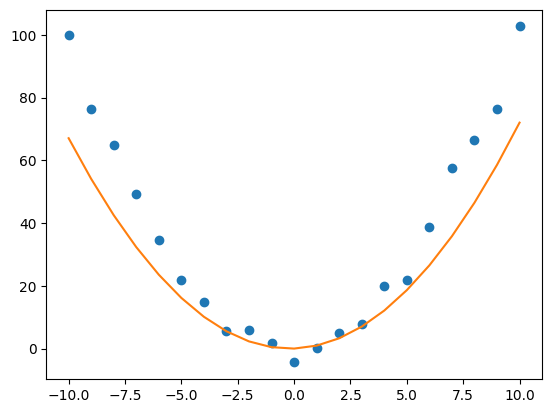

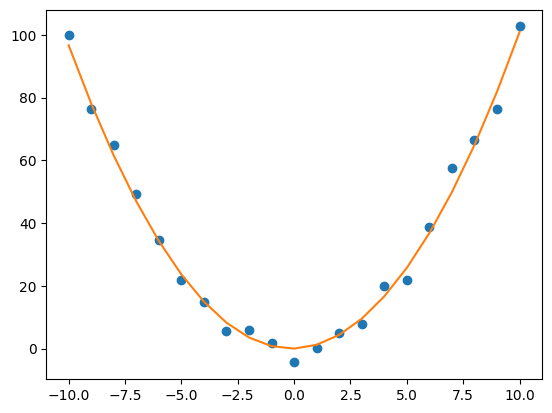

In [93]:
model = Linear2(1, 1)
show_model_estimate(model, x, y)
train_reg(model, x, y, 1000, lr=0.001)
show_model_estimate(model, x, y)

## Linear of Order 3

In [94]:
# d1 = x * w1 + b1
# d2 = x * w2 + b2

# weight = (x * w1 + b1) * (x * w2 + b2)

# out = (x^3 * w1 * w2 * b2 + x^2 * b1 * w2 * b2) 


class Linear3(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.q = nn.Linear(input_size, output_size)
        self.k = nn.Linear(input_size, output_size)
        self.n = output_size
        
    def forward(self, x):
        xq = self.q(x)
        xk = self.k(x)
        
        if len(x.shape) == 2 :
            xq = xq.unsqueeze(1)
            xk = xk.unsqueeze(1)

        weight = xq @ xk.transpose(1, 2) / sqrt(self.n)
        
        if len(x.shape) == 2 :
            x = x.unsqueeze(1)

        out = (weight @ x).squeeze(1)
        return out

4805.04150390625
408.25689697265625
304.528076171875
222.0675048828125
166.46212768554688
119.24510192871094
88.43582153320312
66.03790283203125
48.76799011230469
36.50318145751953


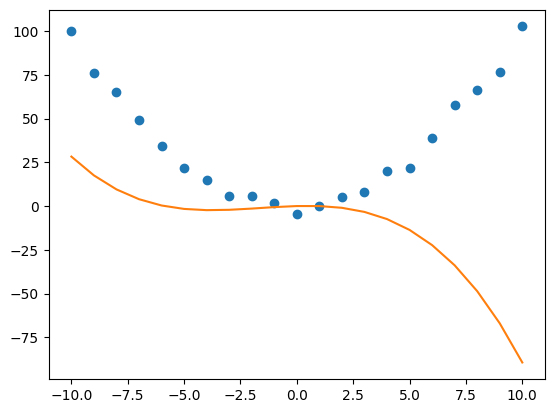

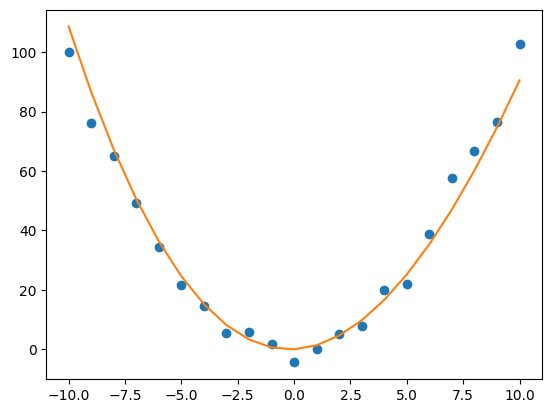

In [100]:
model = Linear3(1, 100)
show_model_estimate(model, x, y)
train_reg(model, x, y, 4000, lr=0.01)
show_model_estimate(model, x, y)

Other forms of higher order neural network

* Spatial Transform
* Attention 


## Dervice transformation matrix from image

In [101]:
class STN(nn.Module):
    def __init__(self):
        super(STN, self).__init__()
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        
    def forward(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

## Select elements from a sequence

In [103]:
from math import sqrt

class Attention(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        
        self.q = nn.Linear(input_size, output_size)
        self.k = nn.Linear(input_size, output_size)
        self.v = nn.Linear(input_size, output_size)
        self.o = nn.Linear(output_size, input_size)
        self.n = output_size

    def forward(self, x):
        xq = self.q(x)
        xk = self.k(x)
        xv = self.v(x)
        
        out = xq @ xk.transpose(1, 2) / sqrt(self.n)
        
        out = F.softmax(out, dim=-1)
        
        out = self.o(out @ xv)
        
        return out

## Convolution 

Derive the convolution kernel from the image itself

In [106]:
def conv2d_iwk(images, kernels, **kwargs):
    """ Apply N kernels to a batch of N images

        Images : N x inC x H x W
        Kernels: N x outC x inC x kH x kW
        Output : N x outC x size(Conv2d)
    """

    data = []
    for image, out_kernels in zip(images, kernels):
        val = simple_conv2d(image, out_kernels, **kwargs)

        c, h, w = val.shape

        data.append(val.view(1, c, h, w))

    return torch.cat(data)


class KernelFinder(torch.nn.Module):
    """ Given a batch of images returns the convolution kernel that should applied to each one of them"""

    def __init__(self, in_channel, out_channel, kernel_size=(3, 2, 2)):
        super(KernelFinder, self).__init__()
        self.kernel_size = (out_channel, *kernel_size)

        # Given a batch of images return a feature set
        # from which the kernel will be computed
        self.features = nn.Sequential(
            nn.Conv2d(in_channel, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Given the previous features for a fiven batch returns
        # the conv kernel that should be applied
        self.kernel_finder = nn.Sequential(
            nn.Linear(90, 32),
            nn.ReLU(True),
            nn.Linear(32, reduce(lambda x, y: x * y, self.kernel_size))
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 10 * 3 * 3)
        x = self.kernel_finder(x)
        x = x.view(-1, *self.kernel_size)
        return x
    
    
class Convolution(torch.nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size):
        self.finder = KernelFinder(in_channel, out_channel, kernel_size)
        
    def forward(self, x):
        kernels = self.find_kernels(x)
        return conv2d_iwk(x, kernels)